## Importing required libraries

In [306]:
%pylab inline
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import random
import glob 
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import IPython.display as ipd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import classification_report,confusion_matrix

Populating the interactive namespace from numpy and matplotlib


C:\Users\shaan\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mean', 'random', 'test', 'grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


* Assigning the path to directory

In [11]:
data_dir = os.getcwd()

### Loading CSV files with Filename and Class Label

In [166]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [16]:
train.head()

ID         Class
0   0         siren
1   1  street_music
2   2      drilling
3   3         siren
4   4      dog_bark

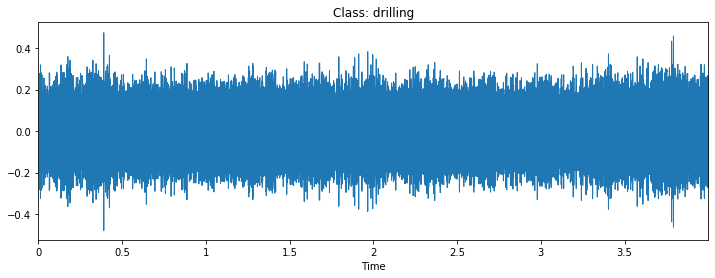

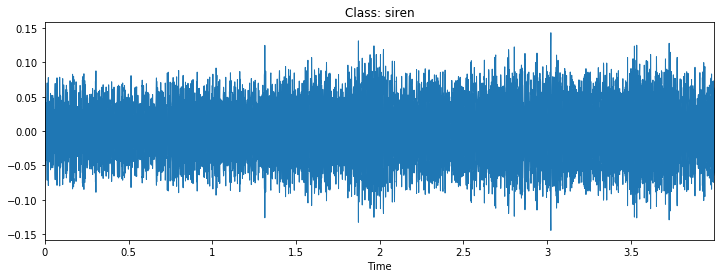

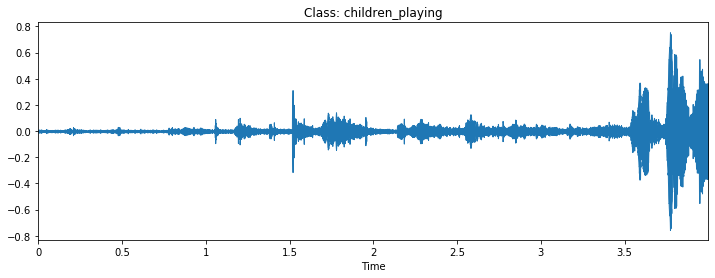

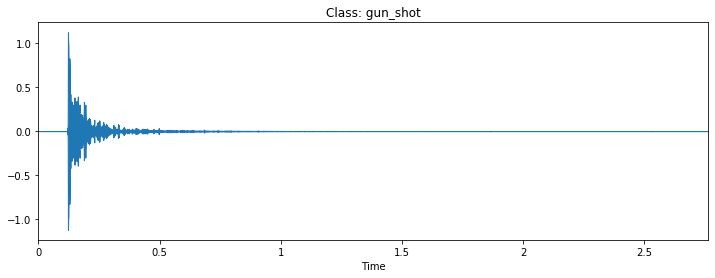

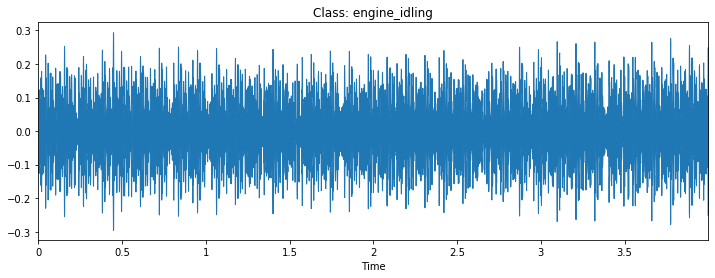

In [336]:
for i in random.sample(range(0, 30), 5):


    audio_name = train.ID[i]
    path = os.path.join(data_dir, 'Train', str(audio_name) + '.wav')

    #print('Class: ', train.Class[i])
    x, sr = librosa.load(path)

    plt.figure(figsize=(12, 4))
    librosa.display.waveplot(x, sr=sr)
    #plt.savefig('Class: {}.png'.format(train.Class[i]))
    plt.title('Class: {}'.format(train.Class[i]))
    plt.show()


* We can see that it is very hard to distinguish between the plot of drilling and siren

## Extracting the features

In [34]:
def parser(data):
   # function to load files and extract features
    features = []
    labels = []
    for row,label in zip(data.ID,data.Class):
    
        file_name = os.path.join(os.path.abspath(data_dir), 'Train', str(row) + '.wav')

       # handle exception to check if there isn't a file which is corrupted
        try:
          # here kaiser_fast is a technique used for faster extraction
            X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
          # we extract mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        except Exception as e:
            print("Error encountered while parsing file: ", file)
            return None, None

        features.append(mfccs)
        labels.append(label)
 
    return features, labels

features, labels = parser(train)


In [39]:
temp = pd.DataFrame({'feature':features,'label':labels})

In [40]:
temp

feature            label
0     [-82.12359, 139.50595, -42.430847, 24.827862, ...            siren
1     [-15.744001, 124.11996, -29.42888, 39.44719, -...     street_music
2     [-123.393654, 15.181944, -50.093338, 7.1418724...         drilling
3     [-213.2787, 89.323616, -55.256165, 12.632098, ...            siren
4     [-237.9265, 135.90247, 39.26844, 21.24023, 9.5...         dog_bark
...                                                 ...              ...
5430  [-214.65845, 178.94125, -1.2636195, 63.96228, ...    engine_idling
5431  [-395.34586, 105.81336, -0.19628958, -7.097912...         dog_bark
5432  [-320.81738, 58.30057, -6.869504, 15.693742, -...    engine_idling
5433  [-277.0318, 141.1457, -36.32912, 39.455746, -0...    engine_idling
5434  [-290.99677, 233.35152, -4.6723485, 4.6523294,...  air_conditioner

[5435 rows x 2 columns]

## Converting to appropriate format required for input 

In [43]:

X = np.array(temp.feature.tolist())
y = np.array(temp.label.tolist())

lb = LabelEncoder()

y = np_utils.to_categorical(lb.fit_transform(y))

### Splitting tha data into Train and Validation

In [144]:

X_train, val_x, y_train, val_y = train_test_split(X, y, test_size=0.2, random_state=42)

## Defining model and performing Grid SearchCV for best parameters

In [104]:
 def create_model(optimizer,init):   
    model = Sequential()

    model.add(Dense(256, input_shape=(40,),activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu',init=init))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_labels,init=init))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    return model

In [105]:

from keras.optimizers import Adam, RMSprop, SGD, Adadelta
model = KerasClassifier(build_fn=create_model, verbose=0)
optimizers = ['rmsprop', 'adam','SGD','adadelta']
init = ['glorot_uniform', 'normal', 'uniform']
batch_size = [16, 32, 64, 128, 256, 512]
epochs = [10,20,30,40,50]
param_grid = dict(optimizer = optimizers,init = init,batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X, y)

C:\Users\shaan\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\shaan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="uniform")`
  import sys
C:\Users\shaan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()


In [106]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.887948 using {'batch_size': 32, 'epochs': 50, 'init': 'uniform', 'optimizer': 'adam'}
0.705060 (0.045449) with: {'batch_size': 16, 'epochs': 10, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.640478 (0.014161) with: {'batch_size': 16, 'epochs': 10, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.161730 (0.005623) with: {'batch_size': 16, 'epochs': 10, 'init': 'glorot_uniform', 'optimizer': 'SGD'}
0.665317 (0.015221) with: {'batch_size': 16, 'epochs': 10, 'init': 'glorot_uniform', 'optimizer': 'adadelta'}
0.751794 (0.011363) with: {'batch_size': 16, 'epochs': 10, 'init': 'normal', 'optimizer': 'rmsprop'}
0.735787 (0.015692) with: {'batch_size': 16, 'epochs': 10, 'init': 'normal', 'optimizer': 'adam'}
0.388224 (0.047661) with: {'batch_size': 16, 'epochs': 10, 'init': 'normal', 'optimizer': 'SGD'}
0.724379 (0.009137) with: {'batch_size': 16, 'epochs': 10, 'init': 'normal', 'optimizer': 'adadelta'}
0.781233 (0.011183) with: {'batch_size': 16, 'epochs': 10, 'init': 'uniform', 

In [107]:
grid.best_params_

{'batch_size': 32, 'epochs': 50, 'init': 'uniform', 'optimizer': 'adam'}

### Defining the Model Architecture with best parameters

In [263]:
num_labels = y.shape[1]
# build model
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam',)

In [264]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 256)               10496     
_________________________________________________________________
activation_41 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_42 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 10)              

### Fitting the model

In [265]:
history = model.fit(X_train, y_train, batch_size=64, epochs=90, validation_data=(val_x, val_y))

Train on 4348 samples, validate on 1087 samples
Epoch 1/90
4348/4348 [==============================] - 0s 81us/step - loss: 12.3848 - accuracy: 0.2015 - val_loss: 1.8536 - val_accuracy: 0.3689
Epoch 2/90
4348/4348 [==============================] - 0s 51us/step - loss: 2.8393 - accuracy: 0.2622 - val_loss: 2.0779 - val_accuracy: 0.3017
Epoch 3/90
4348/4348 [==============================] - 0s 52us/step - loss: 2.1506 - accuracy: 0.2891 - val_loss: 1.9854 - val_accuracy: 0.3882
Epoch 4/90
4348/4348 [==============================] - 0s 50us/step - loss: 1.9972 - accuracy: 0.3176 - val_loss: 1.8867 - val_accuracy: 0.3937
Epoch 5/90
4348/4348 [==============================] - 0s 46us/step - loss: 1.8807 - accuracy: 0.3519 - val_loss: 1.7395 - val_accuracy: 0.4370
Epoch 6/90
4348/4348 [==============================] - 0s 45us/step - loss: 1.7727 - accuracy: 0.3924 - val_loss: 1.6034 - val_accuracy: 0.5281
Epoch 7/90
4348/4348 [==============================] - 0s 42us/step - loss: 1.67

Epoch 57/90
4348/4348 [==============================] - 0s 70us/step - loss: 0.3943 - accuracy: 0.8641 - val_loss: 0.3450 - val_accuracy: 0.9052
Epoch 58/90
4348/4348 [==============================] - 0s 72us/step - loss: 0.3854 - accuracy: 0.8698 - val_loss: 0.3268 - val_accuracy: 0.9098
Epoch 59/90
4348/4348 [==============================] - 0s 71us/step - loss: 0.3637 - accuracy: 0.8733 - val_loss: 0.3200 - val_accuracy: 0.9108
Epoch 60/90
4348/4348 [==============================] - 0s 70us/step - loss: 0.3811 - accuracy: 0.8707 - val_loss: 0.3210 - val_accuracy: 0.9071
Epoch 61/90
4348/4348 [==============================] - 0s 74us/step - loss: 0.3732 - accuracy: 0.8751 - val_loss: 0.3316 - val_accuracy: 0.9006
Epoch 62/90
4348/4348 [==============================] - 0s 71us/step - loss: 0.3736 - accuracy: 0.8728 - val_loss: 0.3314 - val_accuracy: 0.9172
Epoch 63/90
4348/4348 [==============================] - 0s 72us/step - loss: 0.3557 - accuracy: 0.8753 - val_loss: 0.3127 -

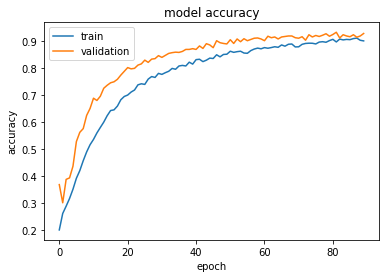

In [266]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

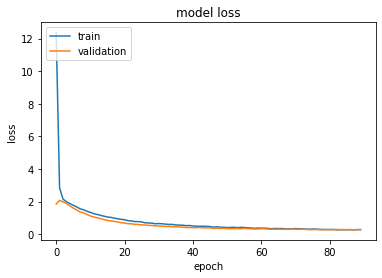

In [267]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Evaluation on Validation Data

In [305]:
train_loss,train_accuracy = model.evaluate(X_train,y_train)
val_loss,val_accuracy = model.evaluate(val_x,val_y)
print('Training Accuracy = %.3f' % (train_accuracy * 100.0),'Training Loss = %.3f' % (train_loss))
print('Validation Accuracy = %.3f' % (val_accuracy * 100.0),'Validation Loss = %.3f' % (val_loss))

1087/1087 [==============================] - 0s 26us/step
Training Accuracy = 98.252 Training Loss = 0.094
Validation Accuracy = 92.732 Validation Loss = 0.279


### Saving the Model architecture and weights

In [269]:
best_model = model.to_json()
with open('urban_sound_model.json','w') as json_file:
    json_file.write(best_model)
model.save_weights('best_model.h5')
print("Saved Model to Disk")

Saved Model to Disk


## Prediction on Test Data

* Extracting features from Test Data

In [270]:
def parser_test_data(data):
   # function to load files and extract features
    features = []
    row_index = []
    for i,row in enumerate(data.ID):
    
        file_name = os.path.join(os.path.abspath(data_dir), 'Test', str(row) + '.wav')

       # handle exception to check if there isn't a file which is corrupted
        try:
          # here kaiser_fast is a technique used for faster extraction
            X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
          # we extract mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        except Exception as e:
            print("Error encountered while parsing file: ", file)
            return None, None

        features.append(mfccs)
        row_index.append(i)
 
    return features,row_index

features, row_index = parser_test_data(test)

In [273]:
len(row_index)

3297

In [274]:
test_data = pd.DataFrame({'features': features})
test_data = np.array(test_data.features.tolist())

### Prediction

In [287]:
prediction = model.predict_classes(test_data)
prediction = lb.inverse_transform(prediction)

In [300]:
i = random.choice(test.index)
audio_name = test.ID[i]
path = os.path.join(data_dir, 'Test', str(audio_name) + '.wav')

print('Class : {}'.format(prediction[i]))
ipd.Audio(path)

Class : engine_idling


In [301]:
i = random.choice(test.index)
audio_name = test.ID[i]
path = os.path.join(data_dir, 'Test', str(audio_name) + '.wav')

print('Class : {}'.format(prediction[i]))
ipd.Audio(path)

Class : drilling


In [290]:
i = random.choice(test.index)
audio_name = test.ID[i]
path = os.path.join(data_dir, 'Test', str(audio_name) + '.wav')

print('Class : {}'.format(prediction[i]))
ipd.Audio(path)

Class : car_horn


In [291]:
i = random.choice(test.index)
audio_name = test.ID[i]
path = os.path.join(data_dir, 'Test', str(audio_name) + '.wav')

print('Class : {}'.format(prediction[i]))
ipd.Audio(path)

Class : siren


In [293]:
i = random.choice(test.index)
audio_name = test.ID[i]
path = os.path.join(data_dir, 'Test', str(audio_name) + '.wav')

print('Class : {}'.format(prediction[i]))
ipd.Audio(path)

Class : drilling


In [298]:
i = random.choice(test.index)
audio_name = test.ID[i]
path = os.path.join(data_dir, 'Test', str(audio_name) + '.wav')

print('Class : {}'.format(prediction[i]))
ipd.Audio(path)

Class : street_music


### Saving the prediction to csv file

In [303]:
submission = pd.DataFrame({'ID':test.ID[row_index],'Class':prediction})

In [304]:
submission.to_csv('submission.csv',index=False)